<b> Food Environment Atlas </b>

<b>Objectives of the Atlas</b>

Food environment factors—such as store/restaurant proximity, food prices, food and nutrition assistance programs, and community characteristics—interact to influence food choices and diet quality. Research has been documenting the complexity of these interactions, but more research is needed to identify causal relationships and effective policy interventions.

The objectives of the Atlas are:

<li>to assemble statistics on food environment indicators to stimulate research on the determinants of food choices and diet quality, and</li>
<li>to provide a spatial overview of a community's ability to access healthy food and its success in doing so.</li>

<b>What information is included in the Atlas?</b>

The Atlas assembles statistics on three broad categories of food environment factors:

<li>Food Choices—Indicators of the community's access to and acquisition of healthy, affordable food, such as: access and proximity to a grocery store; number of foodstores and restaurants; expenditures on fast foods; food and nutrition assistance program participation; food prices; food taxes; and availability of local foods.</li>

<li>Health and Well-Being—Indicators of the community's success in maintaining healthy diets, such as: food insecurity; diabetes and obesity rates; and physical activity levels.</li>

<li>Community Characteristics—Indicators of community characteristics that might influence the food environment, such as: demographic composition; income and poverty; population loss; metro-nonmetro status; natural amenities; and recreation and fitness centers.</li>

The Atlas currently includes over 275 indicators of the food environment. The year and geographic level of the indicators vary to better accommodate data from a variety of sources. Some indicators are at the county level while others are at the State or regional level. The most recent county-level data are used whenever possible.

<b>Data Source :</b> <a href ="https://www.ers.usda.gov/data-products/food-environment-atlas/data-access-and-documentation-downloads/">Click Here </a>

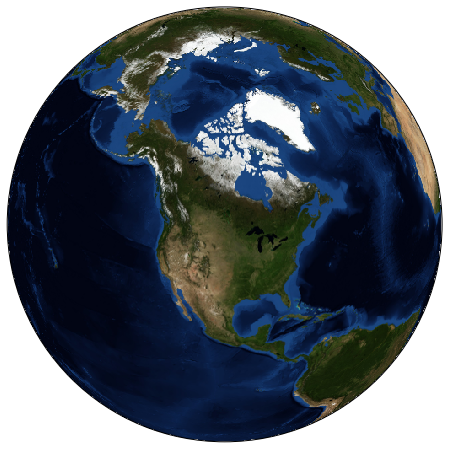

In [188]:
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(8, 8))
m = Basemap(projection='ortho', resolution=None, lat_0=50, lon_0=-100)
m.bluemarble(scale=0.3);

<b> Importing necessary libraries </b>

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<b> Reading the data </b>

In [52]:
xls = pd.ExcelFile("/Users/salilvaidya/Desktop/DA Project/DA_Final_Data.xls")
variables = xls.parse('Variable List')

#Reading Supplementary data
sd_county = xls.parse('Supplemental Data - County')
sd_state = xls.parse('Supplemental Data - State')


In [53]:
names_str = [str(x) for x in variables['Category Code'].unique()]

names_str.remove('LOCAL')

#Dictionary of dataframes
d={}

for i in names_str:
    df_name = i
    df = xls.parse(i)
    d[i]=df

<b> Defining the cleaning function </b>

<b> What to do with cleaning values ? </b>

In the ACCESS df, 
Many counties consistently have NAN values in many columns. Hence, it would be wise to remove the counties altogether as they wouldn't add anything fruitful to the overall analysis. (Can be the same case with other dfs too)

Or shall we import data from closest county ? 

Or is substituting with the mean/median values of the corresponding column in the corresponding state better ? 

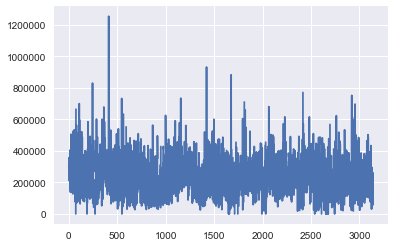

255135.961557


In [54]:
plt.plot(d['ASSISTANCE']['REDEMP_SNAPS12'])
plt.show()
#Calculating mean here because there are less outliers

mean_snaps12 = sum(d['ASSISTANCE']['REDEMP_SNAPS12'][d['ASSISTANCE']['REDEMP_SNAPS12'].notnull()])/len(d['ASSISTANCE']['REDEMP_SNAPS12'][d['ASSISTANCE']['REDEMP_SNAPS12'].notnull()])
print(mean_snaps12)

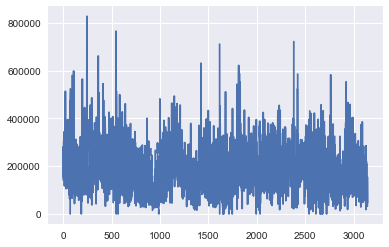

194481.97043


In [55]:
import statistics as s
plt.plot(d['ASSISTANCE']['REDEMP_SNAPS16'])
plt.show()

#Calculating median here because there are many outliers and volatality is high
median_snaps16 = s.median(d['ASSISTANCE']['REDEMP_SNAPS16'][d['ASSISTANCE']['REDEMP_SNAPS16'].notnull()])
print(median_snaps16)

In [56]:
#The cleaning function accepts an uncleaned dictionary and returns the cleaned dictionary

def cleaning(y):
    import warnings
    warnings.filterwarnings("ignore")    
    for i in names_str:
        for j in y[i].columns:
            if ('PCH' in j) or ('PCT' in j) and (i!='HEALTH'):
                y[i]=y[i].drop(labels=j,axis=1)
        
        y[i]=y[i].dropna(thresh=int(len(y[i].columns)/2))
        
        if(i == 'ACCESS'):
            y[i]=y[i][y[i]['LACCESS_POP15'].notnull()]
            
        elif(i == 'HEALTH'):
            y[i]=y[i].drop(labels='PCT_HSPA15',axis=1)
            
            #Filling missing values with an average percentage change in diatebetes and obesity rate for 2008 and 2013 and then appending values
            
            temp=y[i][y[i].State == 'AK'][y[i][y[i].State == 'AK']['PCT_DIABETES_ADULTS08'].notnull()]

            avg=sum((temp['PCT_DIABETES_ADULTS13']-temp['PCT_DIABETES_ADULTS08'])/temp['PCT_DIABETES_ADULTS08']*100)/len(temp)
            
            #Substituting calculated percentage changes by the NaN values
            
            y[i].PCT_DIABETES_ADULTS08 = np.where(y[i].PCT_DIABETES_ADULTS08.isnull(), y[i].PCT_DIABETES_ADULTS13*(1-(avg/100)), y[i].PCT_DIABETES_ADULTS08)

            temp2=y[i][y[i].State == 'AK'][y[i][y[i].State == 'AK']['PCT_OBESE_ADULTS08'].notnull()]

            avg2=sum((temp2['PCT_OBESE_ADULTS13']-temp2['PCT_OBESE_ADULTS08'])/temp2['PCT_OBESE_ADULTS08']*100)/len(temp2)
            
            y[i].PCT_OBESE_ADULTS08 = np.where(y[i].PCT_OBESE_ADULTS08.isnull(), y[i].PCT_OBESE_ADULTS13*(1-(avg/100)), y[i].PCT_OBESE_ADULTS08)
            
            #Converting single Diabetes and Obesity adults rate columns for 2008 and 2013 into percentge change
            #columns becaus they are highly correlated. 
            
            y[i]['PCT_CHG_DIABETES_ADULTS_08_13']=(y[i]['PCT_DIABETES_ADULTS13']-y[i]['PCT_DIABETES_ADULTS08'])/y[i]['PCT_DIABETES_ADULTS08']
            
            y[i]['PCT_CHG_OBESE_ADULTS_08_13']=(y[i]['PCT_OBESE_ADULTS13']-y[i]['PCT_OBESE_ADULTS08'])/y[i]['PCT_OBESE_ADULTS08']
            
            y[i]=y[i].drop(labels=['PCT_DIABETES_ADULTS13','PCT_DIABETES_ADULTS08','PCT_OBESE_ADULTS13','PCT_OBESE_ADULTS08'],axis=1)
            
        elif(i == 'ASSISTANCE'):
            y[i]=y[i].drop(labels='PC_WIC_REDEMP08',axis=1)
            y[i]=y[i].drop(labels='PC_WIC_REDEMP12',axis=1)
            y[i]=y[i].drop(labels='REDEMP_WICS08',axis=1)
            y[i]=y[i].drop(labels='REDEMP_WICS12',axis=1)
            #Dropping SNAP benefits column because we have added state wise benefits data for Year 2016 and 2017.
            y[i]=y[i].drop(labels='PC_SNAPBEN10',axis=1)
            y[i]=y[i].drop(labels='PC_SNAPBEN15',axis=1)
            #Substituting REDEMP_SNAPS 2012 and 2016 values with mean and median values as shown above. 
            y[i]['REDEMP_SNAPS12'].fillna(value=mean_snaps12,inplace=True)
            y[i]['REDEMP_SNAPS16'].fillna(value=median_snaps16,inplace=True)
            
        elif(i == 'PRICES_TAXES'):
            #We observed that there are values missing only for states Hawaii and Alaska. Hence we have guestimated
            #the values from the Internet. 
            
            y[i]['MILK_PRICE10'][y[i]['State']=='AK']=4.26/3.29
            
            y[i]['MILK_PRICE10'][y[i]['State']=='HI']=6.15/3.29
            
            y[i]['SODA_PRICE10'][y[i]['State']=='AK']=1.92/1.50

            y[i]['SODA_PRICE10'][y[i]['State']=='HI']=1.92/1.50
            
            y[i]['MILK_SODA_PRICE10'] = y[i]['MILK_PRICE10']/y[i]['SODA_PRICE10']
            
        elif(i == 'SOCIOECONOMIC'):
            #Dropping counties with many missing columns
            y[i]=y[i].dropna(axis=0)
    return(y)

In [57]:
d=cleaning(d)

#Getting the cleaned dictionary

In [58]:
#Printing the Columns with Number of NA values

for i in names_str:
    print(i,d[i].isnull().sum()[d[i].isnull().sum()>0])


ACCESS Series([], dtype: int64)
STORES Series([], dtype: int64)
RESTAURANTS Series([], dtype: int64)
ASSISTANCE Series([], dtype: int64)
INSECURITY Series([], dtype: int64)
PRICES_TAXES Series([], dtype: int64)
HEALTH Series([], dtype: int64)
SOCIOECONOMIC Series([], dtype: int64)


In [ ]:
#Install plotly before running graphs

<b> Visulization  Function </b>

In [59]:
def plot_maps(t1,Y):
    
    from mpl_toolkits.basemap import Basemap as Basemap
    from matplotlib.patches import Polygon
    import matplotlib.pyplot as plt
    import matplotlib.cm
    % matplotlib inline
    from mpl_toolkits.basemap import Basemap
    from matplotlib.patches import Polygon
    from matplotlib.colors import rgb2hex
    from matplotlib.collections import PatchCollection
    from matplotlib.colors import Normalize
    import numpy as np
    import seaborn as sns
    import math
    import pandas as pd
    
    
    plt.figure(figsize=(20,10))
    
    state_group = t1[['State',Y]].groupby(t1.State).mean()
    
    vals= []
    for i in state_group[Y]:
        vals.append(i)
    
    df=pd.DataFrame(vals,list(state_group.index),columns=[Y])
    
    import plotly 
    plotly.tools.set_credentials_file(username="rgp2126",api_key='iySTB05X8VsCE23Yvjct')
    import plotly.plotly as py
    
    scl = [[-0.2, 'rgb(242,240,247)'],[0.0, 'rgb(218,218,235)'],[0.2, 'rgb(188,189,220)'],\
                [0.4, 'rgb(158,154,200)'],[0.6, 'rgb(117,107,177)'],[0.8, 'rgb(84,39,143)']]

    title = "Variation in " +str(Y)
    data = [ dict(
            type='choropleth',
            colorscale = scl,
            autocolorscale = False,
            locations = list(state_group.index),
            z = df[Y].astype(float),
            locationmode = 'USA-states',
            text = False,
            marker = dict(
                line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
            colorbar = dict(
            title = title)
                ) ]



    layout = dict(
            title = title,
            geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
    fig = dict( data=data, layout=layout )
    return(py.iplot(fig,filename='d3-cloropleth-map'))       
    #plt.title('Filling State Polygons by ' + str(Y))
    #plt.show()

In [60]:
plot_maps(d['HEALTH'],'PCT_CHG_OBESE_ADULTS_08_13')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~rgp2126/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


In [61]:
plot_maps(d['HEALTH'],'PCT_CHG_DIABETES_ADULTS_08_13')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~rgp2126/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


In [62]:
plot_maps(d['SOCIOECONOMIC'],'POVRATE15')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~rgp2126/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


In [63]:
 plot_maps(d['SOCIOECONOMIC'],'METRO13')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~rgp2126/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


<b> Analysis Function </b>

<b> Removing Correlation </b>

After analysing the heat plots of correlation of different dataframes in our dataset, we can observe that there is a high correlation in many predictor variables. 

ACCESS


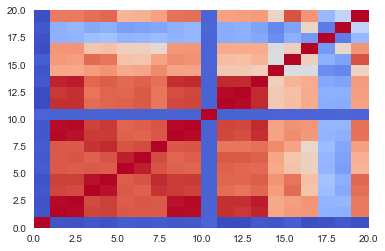

SOCIOECONOMIC


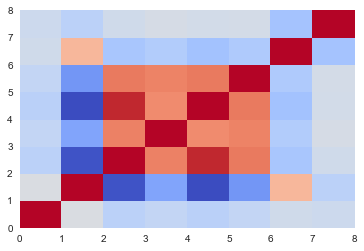

HEALTH


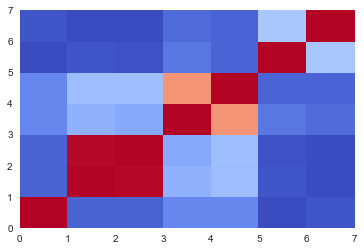

PRICES_TAXES


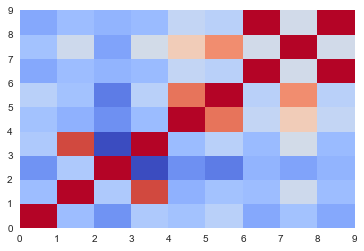

STORES


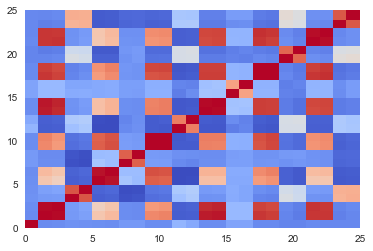

In [64]:
print('ACCESS')
plt.pcolor(d['ACCESS'].corr(),cmap='coolwarm') 
plt.show()

print('SOCIOECONOMIC')
plt.pcolor(d['SOCIOECONOMIC'].corr(),cmap='coolwarm') 
plt.show()

print('HEALTH')
plt.pcolor(d['HEALTH'].corr(),cmap='coolwarm') 
plt.show()

print('PRICES_TAXES')
plt.pcolor(d['PRICES_TAXES'].corr(),cmap='coolwarm') 
plt.show()

print('STORES')
plt.pcolor(d['STORES'].corr(),cmap='coolwarm') 
plt.show()


#We find that many independent variables seem to be highly correlated. Variables which have two values for 
#two years like RECFAC09, RECFAC14


In [65]:
#Function which accepts two tables and reports/removes highly correlated independent vsriables 
#t1 = Table 1
#t2 = Table 2
#c_p = Correlation parameter
#Y = Dependent Variable
def join_rem_corr(t1,t2,c_p,Y):
    
    if(t2 is not None):
        a=t1.shape[0]
        b=t2.shape[0]
        if(a<b):
            res=pd.merge(t1,t2,how='inner')
            temp=res[Y]
            res=res.drop(labels=Y,axis=1)
            
        else:
            res=pd.merge(t2,t1,how='inner')
            temp=res[Y]
            res=res.drop(labels=Y,axis=1)
        
    else:
        res=t1
        
    
    #print('Original Columns: ')
    #print(res.columns)
    dropped=True
    while dropped:
        dropped=False
        
        for i in range(len(res.corr().columns)):
            cols=res.corr().columns
            for j in range(i+1,len(cols)):
                if(abs(res.corr()[cols[i]][cols[j]])>abs(c_p) and cols[i]!=cols[j]):
                    res=res.drop(labels=cols[i],axis=1)
                    cols=cols.drop(cols[i])
                    dropped=True
                    break
    #print('New Columns after dropping correlated columns:')
    
    if(t2 is not None):
        res=pd.concat([res,temp],axis=1)
        #print(res.columns)  
        return(res)
    else:
        return(res)

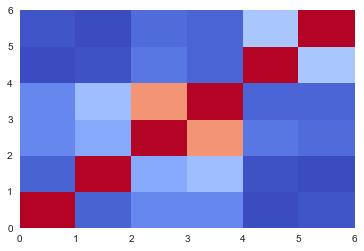

In [66]:

final_data=join_rem_corr(d['HEALTH'],None,0.9,['POVRATE15','PERPOV10'])

plt.pcolor(final_data.corr(),cmap='coolwarm') 
plt.show()

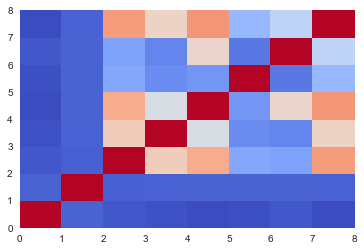

In [67]:
final_data=join_rem_corr(d['ACCESS'],None,0.75,['POVRATE15','PERPOV10'])

plt.pcolor(final_data.corr(),cmap='coolwarm') 
plt.show()

<b> Implementing ML Regressors 
<li> 1. Linear Regression

In [68]:
def linear_regression(t1,t2,Y):
    
    from sklearn.model_selection import train_test_split
    from sklearn import linear_model
    from sklearn.metrics import mean_squared_error, r2_score
    import statsmodels.api as sm
    
    df=join_rem_corr(t1,t2,0.8,Y)
    #print(df.corr())
    train, test = train_test_split(df, test_size = 0.3)
    
    x_train = train[train.columns.drop([Y,'County','State','FIPS'])]
    y_train = train[Y]
    x_test = test[test.columns.drop([Y,'County','State','FIPS'])]
    y_test = test[Y]
    
    
    model = linear_model.LinearRegression()
    model.fit(x_train,y_train)
    #print(model)
    y_pred_training = model.predict(x_train)
    y_pred_testing = model.predict(x_test)
    training_msq = mean_squared_error(y_pred_training,y_train)
    testing_msq = mean_squared_error(y_pred_testing,y_test)
    #print(training_msq,testing_msq)
    print('Train R-Square:',r2_score(y_train,y_pred_training))
    print('Test R-Square:',r2_score(y_test,y_pred_testing))
    
    model2=sm.OLS(y_train,x_train).fit()
    print(model2.summary())
    print(model2.pvalues)

    
    

In [69]:
linear_regression(d['ACCESS'],d['SOCIOECONOMIC'],'POVRATE15')

Train R-Square: 0.890053840792
Test R-Square: 0.892358662216
                            OLS Regression Results                            
Dep. Variable:              POVRATE15   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 1.096e+04
Date:                Mon, 11 Dec 2017   Prob (F-statistic):               0.00
Time:                        21:39:00   Log-Likelihood:                -4855.7
No. Observations:                2184   AIC:                             9735.
Df Residuals:                    2172   BIC:                             9804.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

<li> <b> 2. Decision Tree Regressor

In [70]:
def tree(t1,t2,Y):
    from sklearn.tree import DecisionTreeRegressor
    from sklearn import tree
    from sklearn.model_selection import train_test_split
    from sklearn import linear_model
    from sklearn.metrics import mean_squared_error, r2_score
    
    df=join_rem_corr(t1,t2,0.8,Y)
    #df=pd.merge(t1,t2,how='inner')
    train, test = train_test_split(df, test_size = 0.3)
    
    x_train = train[train.columns.drop([Y,'County','State','FIPS'])]
    y_train = train[Y]
    x_test = test[test.columns.drop([Y,'County','State','FIPS'])]
    y_test = test[Y]
    model = tree.DecisionTreeRegressor(max_depth=3)
    #model = DecisionTreeRegressor(max_depth = 3)
    model.fit(x_train,y_train)
    print("Training R-Square",model.score(x_train,y_train))
    print("Testing R-Square",model.score(x_test,y_test))
    import pydotplus 
    feature_names = x_train.columns
    from IPython.display import Image
    dot_data = tree.export_graphviz(model, out_file=None,feature_names=feature_names)

    graph = pydotplus.graphviz.graph_from_dot_data(dot_data)

    return(Image(graph.create_png()))
    

Training R-Square 0.112476057589
Testing R-Square 0.0418038097974


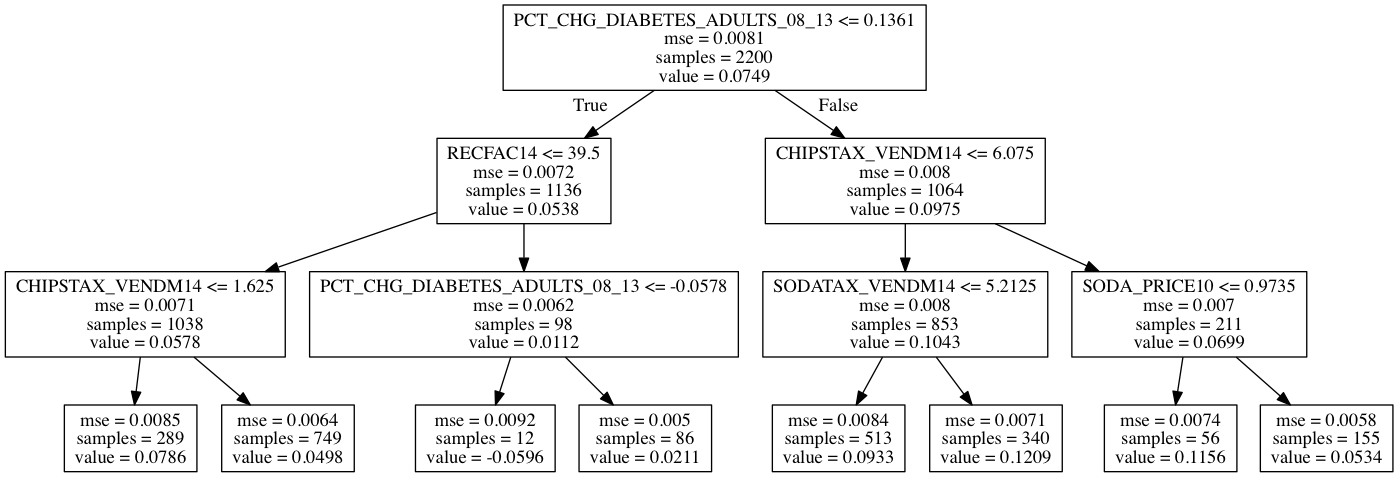

In [71]:
tree(d['HEALTH'],d['PRICES_TAXES'],'PCT_CHG_OBESE_ADULTS_08_13')

<b> <li> 3. Random Forest Regressor

In [72]:
def random_forest(t1,t2,Y):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split
    #df=join_rem_corr(t1,t2,0.8,Y)
    df=pd.merge(t1,t2,how='inner')
    train, test = train_test_split(df, test_size = 0.3)
    
    x_train = train[train.columns.drop([Y,'County','State'])]
    y_train = train[Y]
    x_test = test[test.columns.drop([Y,'County','State'])]
    y_test = test[Y]

    model = RandomForestRegressor()
    #np.ravel flattens the pandas Series into an np array. That's what the classifier needs
    model.fit(x_train,np.ravel(y_train))
    print(model.score(x_test,y_test))
    
    import matplotlib.pyplot as plt
    %matplotlib inline
    importances = model.feature_importances_
    indices = np.argsort(importances)
    feature_names = x_train.columns
    plt.figure(figsize=(12,12))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)),feature_names)
    plt.xlabel('Relative Importance')

0.0124279526039


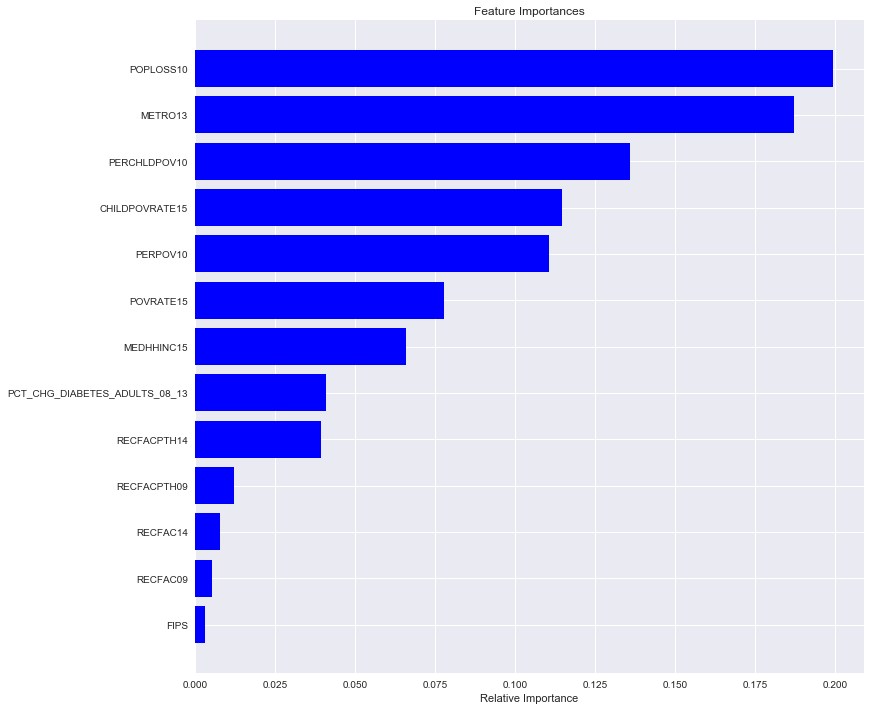

In [73]:
random_forest(d['HEALTH'],d['SOCIOECONOMIC'],'PCT_CHG_OBESE_ADULTS_08_13')

<b> Functionalize the various machine learning models </b>

In [77]:
def linear_regression_model(t1,t2,Y):
    
    from sklearn.model_selection import train_test_split
    from sklearn import linear_model
    from sklearn.metrics import mean_squared_error, r2_score
    
    df=join_rem_corr(t1,t2,0.8,Y)
    #print(df.corr())
    train, test = train_test_split(df, test_size = 0.3)
    
    x_train = train[train.columns.drop([Y,'County','State','FIPS'])]
    y_train = train[Y]
    x_test = test[test.columns.drop([Y,'County','State','FIPS'])]
    y_test = test[Y]
    
    
    model = linear_model.LinearRegression()
    model.fit(x_train,y_train)
    #print(model)
    y_pred_training = model.predict(x_train)
    y_pred_testing = model.predict(x_test)
    training_msq = mean_squared_error(y_pred_training,y_train)
    testing_msq = mean_squared_error(y_pred_testing,y_test)
    #print(training_msq,testing_msq)
    return(model.score(x_train,y_train),model.score(x_test,y_test))
    return (r2_score(y_train,y_pred_training),r2_score(y_test,y_pred_testing))
   
def tree_model(t1,t2,Y):
    from sklearn.tree import DecisionTreeRegressor
    from sklearn import tree
    from sklearn.model_selection import train_test_split
    from sklearn import linear_model
    from sklearn.metrics import mean_squared_error, r2_score
    
    df=join_rem_corr(t1,t2,0.8,Y)
    #df=pd.merge(t1,t2,how='inner')
    train, test = train_test_split(df, test_size = 0.3)
    
    x_train = train[train.columns.drop([Y,'County','State','FIPS'])]
    y_train = train[Y]
    x_test = test[test.columns.drop([Y,'County','State','FIPS'])]
    y_test = test[Y]
    model = tree.DecisionTreeRegressor(max_depth=3)
    #model = DecisionTreeRegressor(max_depth = 3)
    model.fit(x_train,y_train)
    return(model.score(x_train,y_train),model.score(x_test,y_test))

def random_forest_model(t1,t2,Y):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.model_selection import train_test_split
    df=join_rem_corr(t1,t2,0.8,Y)
    #df=pd.merge(t1,t2,how='inner')
    train, test = train_test_split(df, test_size = 0.3)
    
    x_train = train[train.columns.drop([Y,'County','State'])]
    y_train = train[Y]
    x_test = test[test.columns.drop([Y,'County','State'])]
    y_test = test[Y]

    model = RandomForestRegressor()
    #np.ravel flattens the pandas Series into an np array. That's what the classifier needs
    model.fit(x_train,np.ravel(y_train))
    return(model.score(x_test,y_test))
 


<b> Extracting all attributes in a list </b>

In [78]:
HEALTH_list=list(d['HEALTH'].columns.drop(['County','State','FIPS']))
INSECURITY_list=list(d['INSECURITY'].columns.drop(['County','State','FIPS']))
GROCERY_list=list(d['STORES'].columns.drop(['County','State','FIPS']))
ASSISTANCE_list=list(d['ASSISTANCE'].columns.drop(['County','State','FIPS']))
ACCESS_list=list(d['ACCESS'].columns.drop(['County','State','FIPS']))
TAXES_list=list(d['PRICES_TAXES'].columns.drop(['County','State','FIPS']))
SOCIOECONOMIC_list=list(d['SOCIOECONOMIC'].columns.drop(['County','State','FIPS']))
RESTAURANT_list=list(d['RESTAURANTS'].columns.drop(['County','State','FIPS']))

<b> Understanding correlation of socio economic attributes over other datasets </b>

In [79]:
new_d={}



#Regression of Socio Economic over all other data
print("Regressing Socioeconomic over Health")
for i in HEALTH_list:
    new_d['linear regression']=linear_regression_model(d['HEALTH'],d['SOCIOECONOMIC'],i)[1]
    new_d['random forest']=random_forest_model(d['HEALTH'],d['SOCIOECONOMIC'],i)
    new_d['decision tree']=tree_model(d['HEALTH'],d['SOCIOECONOMIC'],i)[1]
    new_d_result = [(value, key) for key, value in new_d.items()]
    print('R-squared for predicting {2}= {0} using  model {1}'.format(max(new_d_result)[0],max(new_d_result)[1],i))
print("\nRegressing Socioeconomic over Insecurity")
for i in INSECURITY_list:    
    new_d['linear regression']=linear_regression_model(d['INSECURITY'],d['SOCIOECONOMIC'],i)[1]
    new_d['random forest']=random_forest_model(d['INSECURITY'],d['SOCIOECONOMIC'],i)
    new_d['decision tree']=tree_model(d['INSECURITY'],d['SOCIOECONOMIC'],i)[1]
    new_d_result = [(value, key) for key, value in new_d.items()]
    print('R-squared for predicting {2}= {0} using  model {1}'.format(max(new_d_result)[0],max(new_d_result)[1],i))
print("\nRegressing Socioeconomic over Stores")
for i in GROCERY_list:    
    new_d['linear regression']=linear_regression_model(d['STORES'],d['SOCIOECONOMIC'],i)[1]
    new_d['random forest']=random_forest_model(d['STORES'],d['SOCIOECONOMIC'],i)
    new_d['decision tree']=tree_model(d['STORES'],d['SOCIOECONOMIC'],i)[1]
    new_d_result = [(value, key) for key, value in new_d.items()]
    print('R-squared for predicting {2}= {0} using  model {1}'.format(max(new_d_result)[0],max(new_d_result)[1],i))
print("\nRegressing Socioeconomic over Assistance")
for i in ASSISTANCE_list:    
    new_d['linear regression']=linear_regression_model(d['ASSISTANCE'],d['SOCIOECONOMIC'],i)[1]
    new_d['random forest']=random_forest_model(d['ASSISTANCE'],d['SOCIOECONOMIC'],i)
    new_d['decision tree']=tree_model(d['ASSISTANCE'],d['SOCIOECONOMIC'],i)[1]
    new_d_result = [(value, key) for key, value in new_d.items()]
    print('R-squared for predicting {2}= {0} using  model {1}'.format(max(new_d_result)[0],max(new_d_result)[1],i))
print("\nRegressing Socioeconomic over Access")
for i in ACCESS_list:    
    new_d['linear regression']=linear_regression_model(d['ACCESS'],d['SOCIOECONOMIC'],i)[1]
    new_d['random forest']=random_forest_model(d['ACCESS'],d['SOCIOECONOMIC'],i)
    new_d['decision tree']=tree_model(d['ACCESS'],d['SOCIOECONOMIC'],i)[1]
    new_d_result = [(value, key) for key, value in new_d.items()]
    print('R-squared for predicting {2}= {0} using  model {1}'.format(max(new_d_result)[0],max(new_d_result)[1],i))


Regressing Socioeconomic over Health
R-squared for predicting RECFAC09= 0.982504526862836 using  model linear regression
R-squared for predicting RECFAC14= 0.9773272643708701 using  model linear regression
R-squared for predicting RECFACPTH09= 0.5846740934988083 using  model decision tree
R-squared for predicting RECFACPTH14= 0.7460188209428226 using  model random forest
R-squared for predicting PCT_CHG_DIABETES_ADULTS_08_13= 0.09463452000818184 using  model linear regression
R-squared for predicting PCT_CHG_OBESE_ADULTS_08_13= 0.09058607909347438 using  model linear regression

Regressing Socioeconomic over Insecurity
R-squared for predicting FOODINSEC_10_12= 0.9983589149683479 using  model random forest
R-squared for predicting FOODINSEC_13_15= 1.0 using  model linear regression
R-squared for predicting CH_FOODINSEC_12_15= 0.9953368614364219 using  model random forest
R-squared for predicting VLFOODSEC_10_12= 1.0 using  model linear regression
R-squared for predicting VLFOODSEC_13_15

<b>Map proportion of obese nationals and correlate their presence with availibility of fast-food restaurants and fitness centres </b>

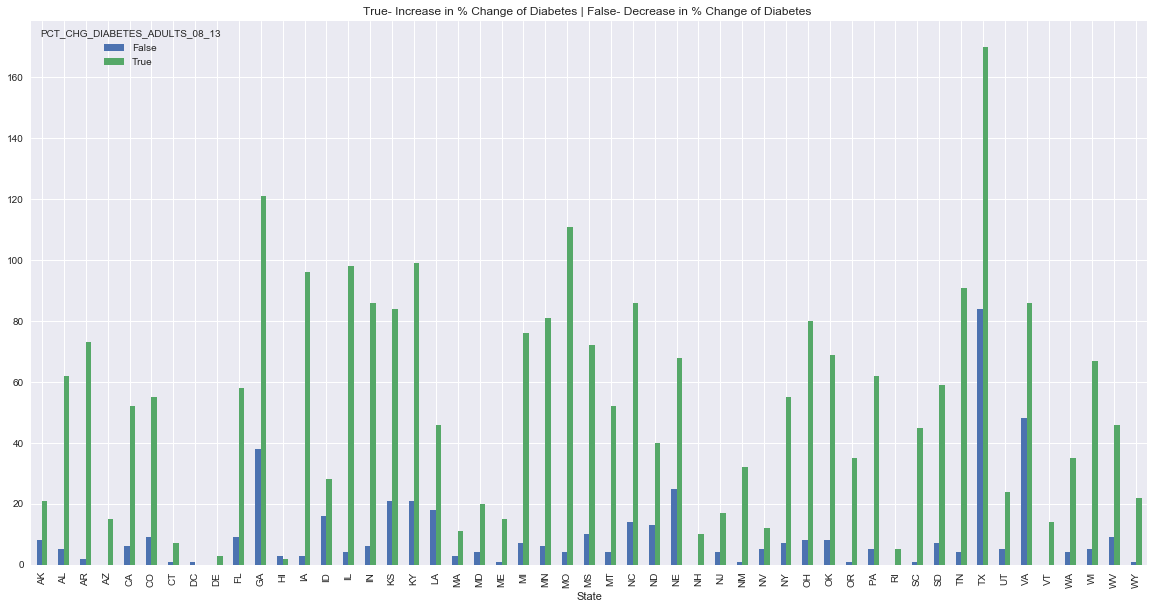

In [80]:
%matplotlib inline
#Understanding the relationship between % Obesity across Fast Food restaurants
#linear_regression(d['HEALTH'],d['RESTAURANTS'],'PCT_CHG_OBESE_ADULTS_08_13')
#Computing change in Expenditure in Fast Food restaurants between 2008 and 2013
d['RESTAURANTS']['PCT_CHG_FFR_SALES_08_13']=((d['RESTAURANTS']['PC_FFRSALES12']-d['RESTAURANTS']['PC_FFRSALES07'])/d['RESTAURANTS']['PC_FFRSALES07'])*100
#Computing change in Recreation/Fitness Facilities between 2008 and 2013
d['HEALTH']['PCT_CHG_RECFA_SALES_08_13']=((d['HEALTH']['RECFACPTH14']-d['HEALTH']['RECFACPTH09'])/d['HEALTH']['RECFACPTH09'])*100
d['ASSISTANCE']['PCT_CHG_REDEMP']=((d['ASSISTANCE']['REDEMP_SNAPS16']-d['ASSISTANCE']['REDEMP_SNAPS12'])/d['ASSISTANCE']['REDEMP_SNAPS12'])*100
d['ACCESS']['PCT_CHG_LOWI_15_10']=((d['ACCESS']['LACCESS_LOWI15']-d['ACCESS']['LACCESS_LOWI10'])/d['ACCESS']['LACCESS_LOWI10'])*100
#Mapping Change % Diabetes Adults across states
state_group_diab = df.groupby([d['HEALTH']['State'],d['HEALTH'].PCT_CHG_DIABETES_ADULTS_08_13>0])
state_group_diab.size().unstack().plot(kind='bar',title="True- Increase in % Change of Diabetes | False- Decrease in % Change of Diabetes ",figsize=(20,10))


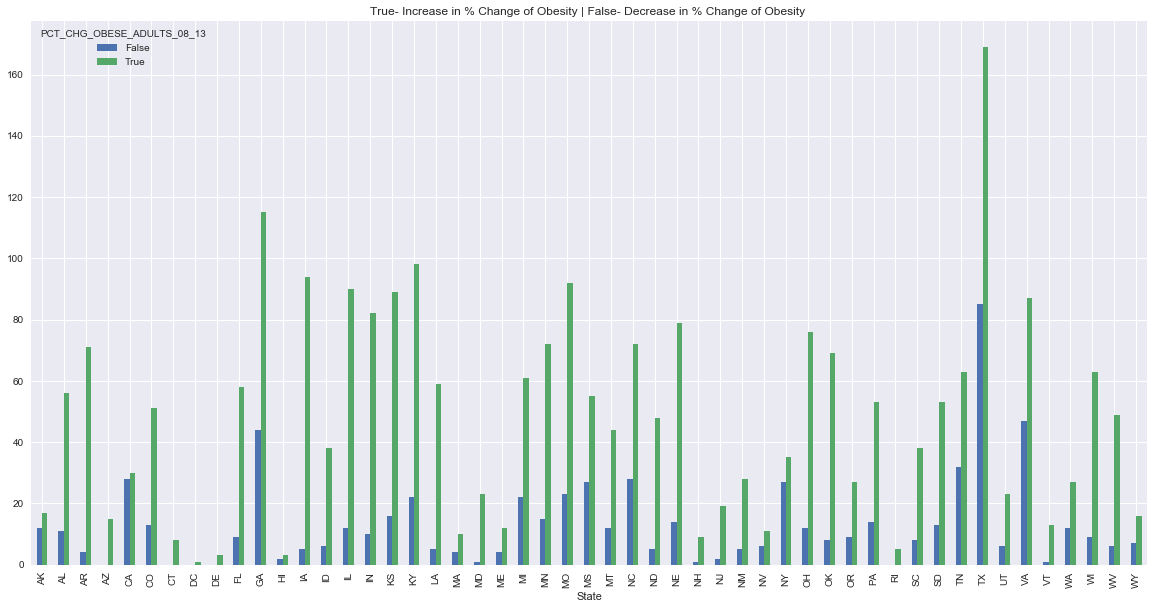

In [81]:
#Mapping Change % Obese Adults across states
state_group_ob = df.groupby([d['HEALTH']['State'],d['HEALTH'].PCT_CHG_OBESE_ADULTS_08_13>0])
state_group_ob.size().unstack().plot(kind='bar',title="True- Increase in % Change of Obesity | False- Decrease in % Change of Obesity ",figsize=(20,10))


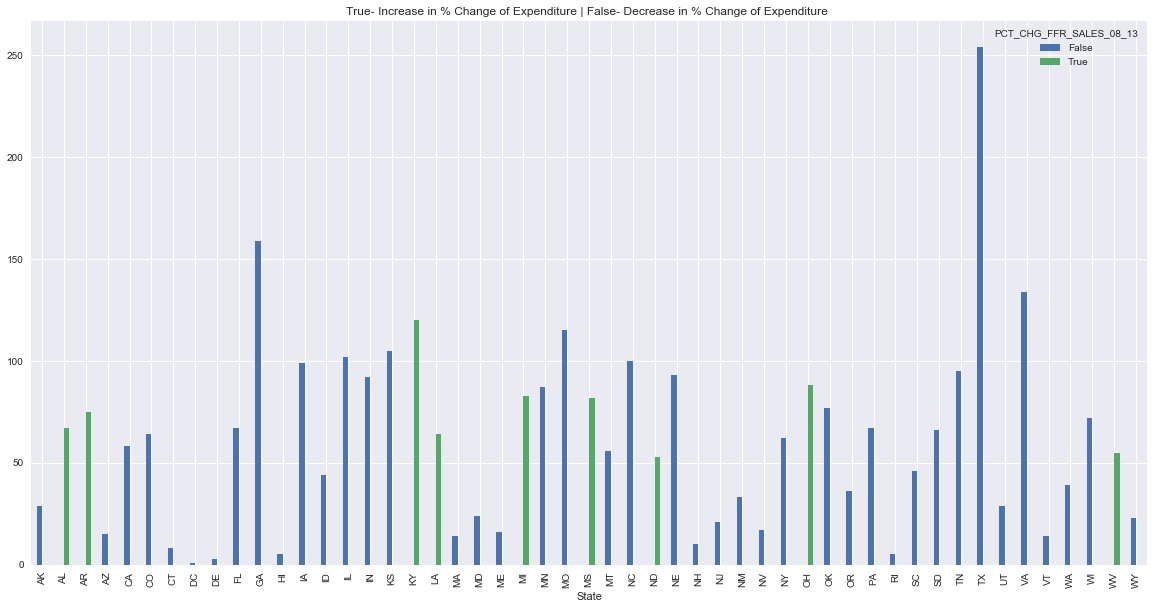

In [82]:
#Mapping Change % Expenditure in Fast Food restaurants across states
state_group_obff = df.groupby([d['RESTAURANTS']['State'],d['RESTAURANTS'].PCT_CHG_FFR_SALES_08_13>0])
state_group_obff.size().unstack().plot(kind='bar',title="True- Increase in % Change of Expenditure | False- Decrease in % Change of Expenditure ",figsize=(20,10))


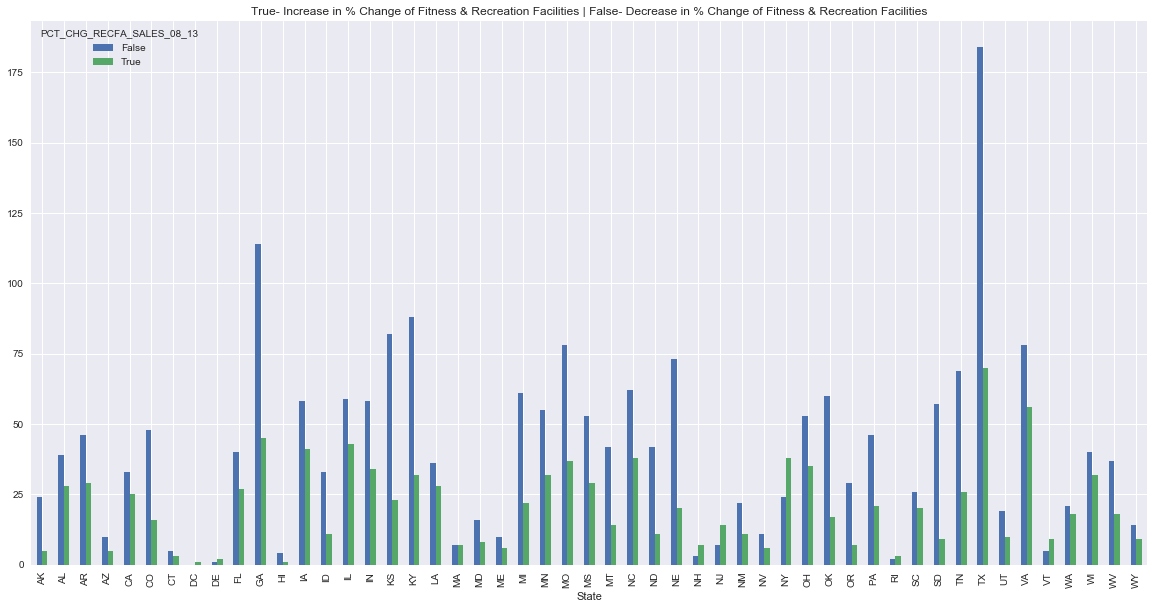

In [83]:
#Mapping Change % Recreation/Fitness Facilities across states
state_group_recfa = df.groupby([d['HEALTH']['State'],d['HEALTH'].PCT_CHG_RECFA_SALES_08_13>0])
state_group_recfa.size().unstack().plot(kind='bar',title="True- Increase in % Change of Fitness & Recreation Facilities | False- Decrease in % Change of Fitness & Recreation Facilities",figsize=(20,10))


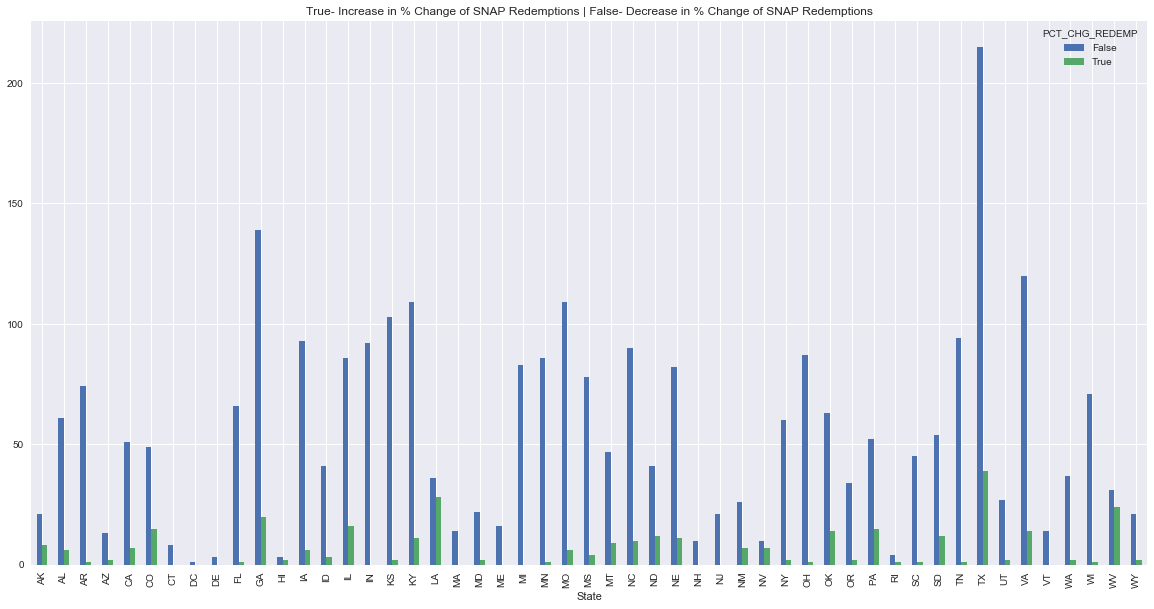

In [84]:
#Mapping Change % SNAP Redemption
state_group_redemp = df.groupby([d['ASSISTANCE']['State'],d['ASSISTANCE'].PCT_CHG_REDEMP>0])
state_group_redemp.size().unstack().plot(kind='bar',title="True- Increase in % Change of SNAP Redemptions | False- Decrease in % Change of SNAP Redemptions",figsize=(20,10))



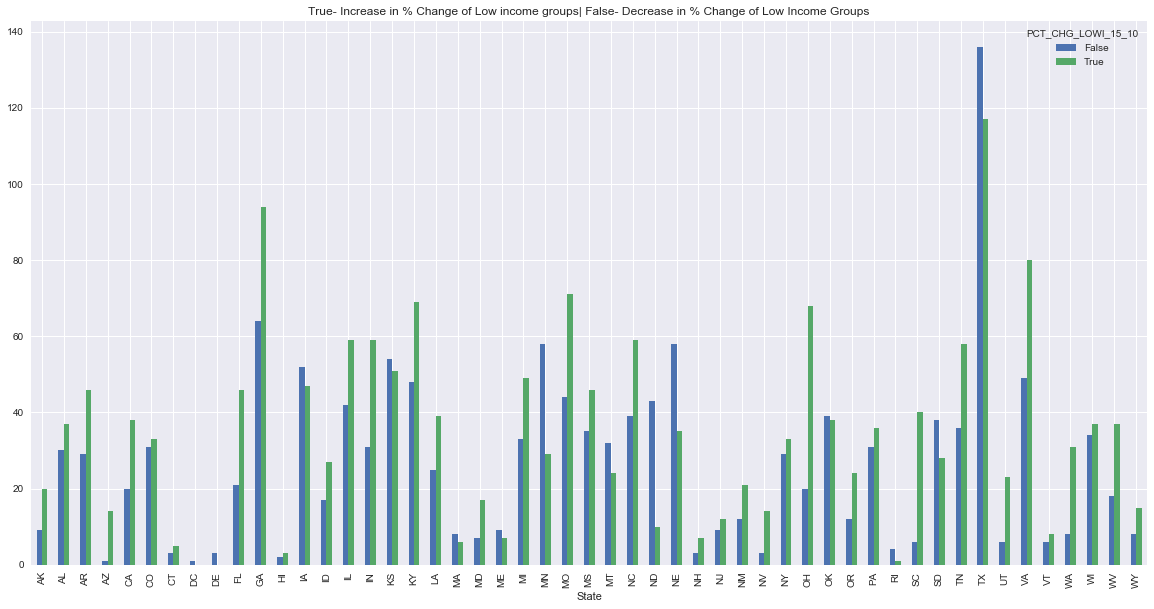

In [85]:
state_group_li1510 = df.groupby([d['ACCESS']['State'],d['ACCESS'].PCT_CHG_LOWI_15_10>0])
state_group_li1510.size().unstack().plot(kind='bar',title="True- Increase in % Change of Low income groups| False- Decrease in % Change of Low Income Groups",figsize=(20,10))